In [1]:
import numpy 
import pandas as pd
import tensorflow 
import nltk
import gensim
import re
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors
from tqdm import tqdm
from konlpy.tag import Mecab
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras.preprocessing.text import Tokenizer

print(numpy.__version__)
print(pd.__version__)
print(tensorflow.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


# 1. 데이터 가져오기

In [2]:
# CSV 파일 경로 설정 (ChatbotData.csv 파일 경로로 변경하세요)
file_path = '/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv'

# CSV 파일 읽기
data = pd.read_csv(file_path)

# 질문과 답변을 각각 저장
questions = data['Q'].tolist()
answers = data['A'].tolist()

# 데이터 예시 출력
print("Number of questions:", len(questions))
print("Number of answers:", len(answers))
print("\nExample questions and answers:")
for i in range(5):  # 예시로 5개의 질문과 답변 출력
    print(f"Q: {questions[i]}")
    print(f"A: {answers[i]}")

Number of questions: 11823
Number of answers: 11823

Example questions and answers:
Q: 12시 땡!
A: 하루가 또 가네요.
Q: 1지망 학교 떨어졌어
A: 위로해 드립니다.
Q: 3박4일 놀러가고 싶다
A: 여행은 언제나 좋죠.
Q: 3박4일 정도 놀러가고 싶다
A: 여행은 언제나 좋죠.
Q: PPL 심하네
A: 눈살이 찌푸려지죠.


# 2. 전처리

In [3]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 영문자를 모두 소문자로 변환
    sentence = sentence.lower()
    # 넷 이상의 공백을 탭 문자로 치환
    sentence = re.sub(r'\s{4,}', '\t', sentence)
    # 둘 이상의 공백을 하나의 공백으로 치환
    sentence = re.sub(r'\s{2,}', ' ', sentence)
    # 영문자, 한글, 숫자, 주요 특수문자를 제외한 모든 문자 제거
    sentence = re.sub(r'[^a-zA-Z0-9가-힣.,!? ]', '', sentence)
    # 문자열 양 끝 공백 제거
    sentence = sentence.strip()
    return sentence


In [4]:
# Step 3: 데이터 토큰화 및 정제

mecab = Mecab()

def build_corpus(src_sentences, tgt_sentences, tokenizer, max_length=20):
    src_corpus = []
    tgt_corpus = []
    src_seen = set()
    tgt_seen = set()

    for src, tgt in zip(src_sentences, tgt_sentences):
        # 전처리
        src = preprocess_sentence(src)
        tgt = preprocess_sentence(tgt)

        # 토큰화
        src_tokens = tokenizer.morphs(src)
        tgt_tokens = tokenizer.morphs(tgt)

        # 길이 제한
        if len(src_tokens) > max_length or len(tgt_tokens) > max_length:
            continue

        # 중복 제거
        src_tuple = tuple(src_tokens)
        tgt_tuple = tuple(tgt_tokens)

        if src_tuple in src_seen or tgt_tuple in tgt_seen:
            continue

        src_seen.add(src_tuple)
        tgt_seen.add(tgt_tuple)

        src_corpus.append(src_tokens)
        tgt_corpus.append(tgt_tokens)

    return src_corpus, tgt_corpus

que_corpus, ans_corpus = build_corpus(questions, answers, mecab)

# Lengths of corpora
print(f'Length of que_corpus: {len(que_corpus)}')
print(f'Length of ans_corpus: {len(ans_corpus)}')

Length of que_corpus: 7571
Length of ans_corpus: 7571


# 4.agumentaion

In [5]:
# Step 4: Augmentation
import gensim
model_path = '/aiffel/aiffel/transformer_chatbot/data/ko.bin'
wv = gensim.models.Word2Vec.load(model_path)

def lexical_sub(sentence, word2vec):
    import random

    res = []
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res.append(_to)
        else: res.append(tok)

    return res


In [6]:
src_temp = []
tgt_temp = []

que_arg = []
ans_arg = []

In [7]:
augmentation_iterations = 3  # 어규멘테이션을 여러 번 반복

for iteration in range(augmentation_iterations):
    print(f"Augmentation iteration: {iteration + 1}")
    for i in range(len(que_corpus)):
        que_temp = lexical_sub(que_corpus[i], wv)
        ans_temp = lexical_sub(ans_corpus[i], wv)
        if que_temp is not None and ans_temp is not None:
            que_arg.append(que_temp)
            ans_arg.append(ans_temp)
    
    print(f"After iteration {iteration + 1}, number of augmented questions: {len(que_arg)}")
    print(f"After iteration {iteration + 1}, number of augmented answers: {len(ans_arg)}")


Augmentation iteration: 1


/tmp/ipykernel_275/1583984763.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


After iteration 1, number of augmented questions: 5809
After iteration 1, number of augmented answers: 5809
Augmentation iteration: 2
After iteration 2, number of augmented questions: 11548
After iteration 2, number of augmented answers: 11548
Augmentation iteration: 3
After iteration 3, number of augmented questions: 17288
After iteration 3, number of augmented answers: 17288


In [8]:
src_temp = que_arg    + que_corpus + que_corpus
tgt_temp = ans_corpus + ans_arg    + ans_corpus

In [9]:
que_corpus = src_temp
ans_corpus = tgt_temp

In [10]:
# 데이터를 비교하여 어규멘테이션이 잘 되었는지 확인
check_length = min(20, len(que_corpus), len(que_arg))
for i in range(check_length):
    if que_corpus[i] != que_arg[i]:
        print(f"Original: {que_corpus[i]}, Augmented: {que_arg[i]}")
        print(f"Index: {i}")

In [11]:
print(len(que_corpus))
print(len(ans_corpus))

32430
32430


In [12]:

# Step 5: 데이터 벡터화
def add_start_end_tokens(corpus):
    new_corpus = []
    for sentence in corpus:
        if sentence is not None:
            if isinstance(sentence, list):
                new_sentence = ["<start>"] + sentence + ["<end>"]
            else:
                new_sentence = ["<start>"] + sentence.split() + ["<end>"]
            new_corpus.append(new_sentence)
    return new_corpus

ans_corpus = add_start_end_tokens(ans_corpus)

# None 값을 제거하는 필터링
que_corpus = [sentence for sentence in que_corpus if sentence is not None]
ans_corpus = [sentence for sentence in ans_corpus if sentence is not None]

# 데이터 샘플 출력
print(f'First question sample: {que_corpus[0]}')
print(f'First answer sample: {ans_corpus[0]}')

all_corpus = que_corpus + ans_corpus
tokenizer = Tokenizer(filters='', oov_token="<unk>")
tokenizer.fit_on_texts([' '.join(sentence) for sentence in all_corpus])

# <start> 및 <end> 토큰 인덱스 확인
print(f'<start> token index: {tokenizer.word_index["<start>"]}')
print(f'<end> token index: {tokenizer.word_index["<end>"]}')

que_sequences = tokenizer.texts_to_sequences([' '.join(sentence) for sentence in que_corpus])
ans_sequences = tokenizer.texts_to_sequences([' '.join(sentence) for sentence in ans_corpus])

max_length = 20
enc_train = pad_sequences(que_sequences, maxlen=max_length, padding='post')
dec_train = pad_sequences(ans_sequences, maxlen=max_length, padding='post')

# 결과 확인
print(f'Encoder input shape: {enc_train.shape}')
print(f'Decoder input shape: {dec_train.shape}')
print(f'First encoder input: {enc_train[0]}')
print(f'First decoder input: {dec_train[0]}')

# Special tokens
START_TOKEN = tokenizer.word_index["<start>"]
END_TOKEN = tokenizer.word_index["<end>"]


First question sample: ['12', '시', '끗', '!']
First answer sample: ['<start>', '하루', '가', '또', '가', '네요', '.', '<end>']
<start> token index: 3
<end> token index: 4
Encoder input shape: (32430, 20)
Decoder input shape: (32430, 20)
First encoder input: [2696  226 3694  119    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
First decoder input: [  3 297   9 151   9  41   2   4   0   0   0   0   0   0   0   0   0   0
   0   0]


In [13]:
vocab_size = len(tokenizer.word_index) + 1

# 모델정의

In [14]:
import tensorflow as tf
import numpy as np

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [15]:

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [16]:

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [17]:

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [18]:

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [19]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [20]:

class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [21]:

class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [22]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [23]:
# Step 6: 모델 훈련
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

n_layers = 2
d_model = 256
n_heads = 8
d_ff = 512
dropout_rate = 0.1
pos_len = max_length

transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    pos_len=pos_len,
    dropout=dropout_rate,
    shared_fc=True,
    shared_emb=True)

learning_rate = LearningRateScheduler(d_model, warmup_steps=4000)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns





In [24]:

transformer = Transformer(n_layers=2, d_model=512, n_heads=8, d_ff = 1024, src_vocab_size=20000, tgt_vocab_size=20000, pos_len=200, dropout=0.5)

In [26]:
BATCH_SIZE = 64
EPOCHS = 5


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch  5: 100%|██████████| 507/507 [00:37<00:00, 13.53it/s, Loss 1.2778]


In [29]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from statistics import mean
# Translation function
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = pad_sequences([tokens], maxlen=max_length, padding='post')
    ids = []
    output = tf.expand_dims([START_TOKEN], 0)   
    for i in range(max_length):
        enc_mask, dec_enc_mask, dec_mask = generate_masks(padded_tokens, output)
        predictions, _, _, _ = model(padded_tokens, output, enc_mask, dec_enc_mask, dec_mask)
        predicted_id = tf.argmax(predictions[0, -1, :]).numpy()
        if predicted_id == END_TOKEN:
            return tgt_tokenizer.sequences_to_texts([ids])[0]
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    return tgt_tokenizer.sequences_to_texts([ids])[0]

# Generate translations
input_sentences = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있다는 소리야."
]

translations = []
for sentence in input_sentences:
    tokens = tokenizer.texts_to_sequences([preprocess_sentence(sentence)])[0]
    translation = translate(tokens, transformer, tokenizer, tokenizer)
    translations.append(translation)

# Display translations
for i, translation in enumerate(translations):
    print(f"{i+1}. {translation} . <end>")

# BLEU score calculation
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference], candidate, weights=weights, smoothing_function=SmoothingFunction().method1)



# Calculate individual BLEU scores
bleu_scores = []
for reference, candidate in zip(references, candidates):
    score = calculate_bleu(reference, candidate)
    bleu_scores.append(score)
    print(f"BLEU: {score}")

# Average BLEU score
average_bleu = mean(bleu_scores)
print("\nAverage BLEU-Total:", average_bleu)

1. 연락 은 싸움 의 씨앗 이 죠 . . <end>
2. 좋 은 선택 이 아니 에요 . . <end>
3. 성공 하 길 바랍니다 . . <end>
4. 연락 은 싸움 의 씨앗 이 죠 . . <end>
BLEU: 0.5623413251903491
BLEU: 0.5623413251903491
BLEU: 0.1778279410038923
BLEU: 1.0

Average BLEU-Total: 0.5756276478461476


2회차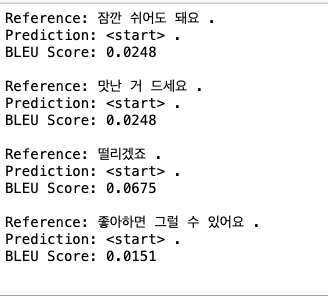

마찬가지로 진행을 했지만 역시 w2v가 잘못불러와졌으며 여기서는 학습부분도 제대로 진행되지않았는데 이전 테스트와 같은 값이 나온것이 의아했다. 아마도 증강을 하며 none이 너무 많아서 시작 토큰만 학습되어 시작토큰에 해당하는 값만으로 학습이 진행된듯하다.

회고
- 배운 점
트렌스포머 모델을 사용해 번역과 챗봇기능을 구현하는 걸 배울수 있었다.또한 데이터 아규먼테이션을 하는 다양한 방법들을 볼수 있었습니다.
- 아쉬운 점
 역시 버전에 문제가 있는 것들이 있어 해당 오류를 잡는데 시간이 걸려 더 다양한 테스트를 진행하지 못해 아쉬웠습니다.
- 느낀 점
코드가 정상작동 안하면... 데이터 형식과 import한 모듈의 버전이 너무 최신이라 맞지않는 부분이 있는지 살펴보아야함을 세삼 느낍니다.
- 어려웠던 점
지난주 조퇴로 인해 해당내용들을 학습하지 못한 상태로 프로젝트를 진행하여 깊은 이해가 수반된 프로젝트는 아니였습니다. 추후 다시 학습을 진행해야할것같습니다.